# Initiation

In [1]:
# To manipulate arrays
import numpy as np 

# To handle track DataFrames
import pandas as pd

# For working with x-arrays
import xarray as xr

# To import images
from skimage import io 
from skimage.io import imread

# For TrackPy
import trackpy as tp

# To make plots
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()  

# To work inline; change to %matplotlib notebook for interactive plotting
%matplotlib inline 

# Napari 
%gui qt5 
from skimage import data
import napari

# Image processing and filters
from skimage.filters import difference_of_gaussians

# For directories 
import os
from pathlib import Path, PureWindowsPath # for working with windows paths

# For reloading a library when testing
import importlib

# For deleting/reloading modules in another file for code testing
import sys

# Import trackArrayTools
cwd = os.getcwd()
os.chdir("../croparray")
import crop_array_tools as ca
os.chdir(cwd)


plt.style.use('dark_background')

# Create Crop Array

To do: 
1. I should probably make a unique id layer (maybe uid), so I can use groupby and map to map arbitrary functions to individual crops.

In [2]:
# Enter in the following:
video_3D_directory = r'../database'
video_3D_filename = r'Hela_confocal.tif'        
csv_filename = r'Crops_Hela_confocal.csv'

In [3]:
# Read in video; note I added an fov dimension using np.array since this is only 1 fov
video_3D = np.array([imread(os.path.join(video_3D_directory,video_3D_filename))])
video_3D.shape # dimensions MUST be (fov, f = frame, z, y, x, ch)

(1, 33, 7, 472, 312, 3)

In [4]:
# Read in csv; note minimal need columns to be used for fov = field of view, f = frame, id = crop/track id #, yc = y-center position of crop, xc - x-center position of crop
spots = pd.read_csv(os.path.join(video_3D_directory, csv_filename)) 
# Rename the Trackmate columns to crop array standards of fov, f, id, yc, and xc
spots.rename(columns={'POSITION_X': 'xc','POSITION_Y': 'yc', 'FRAME': 'f','TRACK_ID':'id'}, inplace=True, errors='raise')
 # Here we need to create an fov column since there was only 1 fov with the sample dataset. Can give it a name, but note that in the crop array it will be assigned a unique fov integer number starting from 0
spots['fov']=video_3D_filename  
# can include other optional columns for making layers, like 'ID', and 'MEAN_INTENSITY'
spots = spots[['fov','id','f','yc','xc','ID','MEAN_INTENSITY']]  
spots.head()

,fov,id,f,yc,xc,ID,MEAN_INTENSITY
0,Hela_confocal.tif,0,0,14.0,69.0,10777,1097.358
1,Hela_confocal.tif,0,1,13.0,69.0,11306,1135.689
2,Hela_confocal.tif,0,2,14.0,69.0,11135,1129.935
3,Hela_confocal.tif,0,3,14.0,69.0,10954,1129.091
4,Hela_confocal.tif,0,4,13.0,70.0,11466,1120.109


In [5]:
# create crop array using minimal arguments
my_ca = ca.create_crop_array(video_3D, spots)
my_ca

Original video dimensions:  (1, 33, 7, 472, 312, 3)
Padded video dimensions:  (1, 33, 7, 484, 324, 3)
Max # of spots per frame:  104
Shape of numpy array to hold all crop intensity data:  (1, 104, 33, 7, 11, 11, 3)
Shape of xc and yc numpy arrays:  (1, 104, 33, 3)
Shape of extra my_layers numpy array:  (3, 1, 104, 33)


<xarray.Dataset>
Dimensions:         (fov: 1, n: 104, t: 33, z: 7, y: 11, x: 11, ch: 3)
Coordinates:
  * fov             (fov) int32 0
  * n               (n) int64 0 1 2 3 4 5 6 7 8 ... 96 97 98 99 100 101 102 103
  * t               (t) int32 0 1 2 3 4 5 6 7 8 9 ... 24 25 26 27 28 29 30 31 32
  * z               (z) int32 0 1 2 3 4 5 6
  * y               (y) int32 -5 -4 -3 -2 -1 0 1 2 3 4 5
  * x               (x) int32 -5 -4 -3 -2 -1 0 1 2 3 4 5
  * ch              (ch) int32 0 1 2
Data variables:
    int             (fov, n, t, z, y, x, ch) int32 23 17 37 21 37 ... 0 0 0 0 0
    xc              (fov, n, t, ch) int32 75 75 75 75 75 75 75 ... 0 0 0 0 0 0 0
    yc              (fov, n, t, ch) int32 20 20 20 19 19 19 20 ... 0 0 0 0 0 0 0
    dx              int32 1
    dy              int32 1
    dz              int32 1
    dt              int32 1
    id              (fov, n, t) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ID              (fov, n, t) float64 1.078e+04 1.131e+04 ... 0.0 0.0
    MEAN_INTENSITY  (fov, n, t) float64 1.097e+03 1.136e+03 1.13e+03 ... 0.0 0.0
Attributes:
    units:    ['space', 'time']
    name:     video_filename
    date:     video_date

In [6]:
# create crop array with all key word arguments. This is recommended to keep track of all information for later databasing
temp_name = video_3D_directory+'/'+video_3D_filename
my_ca = ca.create_crop_array(video_3D, spots, dx=130, dy=130, dz=500, dt=1, units=['nm','s'], name=temp_name, date='2021-12-25')
my_ca.attrs['notes'] = 'A crop array with ch0 = MYH9 mRNA, ch1 = nascent myo2A peptide signal (anti-FLAG Fab + smFLAG), ch3 = mature protein GFP-myo2A. mRNA spots were tracked using TrackMate.'
my_ca

Original video dimensions:  (1, 33, 7, 472, 312, 3)
Padded video dimensions:  (1, 33, 7, 484, 324, 3)
Max # of spots per frame:  104
Shape of numpy array to hold all crop intensity data:  (1, 104, 33, 7, 11, 11, 3)
Shape of xc and yc numpy arrays:  (1, 104, 33, 3)
Shape of extra my_layers numpy array:  (3, 1, 104, 33)


<xarray.Dataset>
Dimensions:         (fov: 1, n: 104, t: 33, z: 7, y: 11, x: 11, ch: 3)
Coordinates:
  * fov             (fov) int32 0
  * n               (n) int64 0 1 2 3 4 5 6 7 8 ... 96 97 98 99 100 101 102 103
  * t               (t) int32 0 1 2 3 4 5 6 7 8 9 ... 24 25 26 27 28 29 30 31 32
  * z               (z) int32 0 500 1000 1500 2000 2500 3000
  * y               (y) int32 -650 -520 -390 -260 -130 0 130 260 390 520 650
  * x               (x) int32 -650 -520 -390 -260 -130 0 130 260 390 520 650
  * ch              (ch) int32 0 1 2
Data variables:
    int             (fov, n, t, z, y, x, ch) int32 23 17 37 21 37 ... 0 0 0 0 0
    xc              (fov, n, t, ch) int32 75 75 75 75 75 75 75 ... 0 0 0 0 0 0 0
    yc              (fov, n, t, ch) int32 20 20 20 19 19 19 20 ... 0 0 0 0 0 0 0
    dx              int32 130
    dy              int32 130
    dz              int32 500
    dt              int32 1
    id              (fov, n, t) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ID              (fov, n, t) float64 1.078e+04 1.131e+04 ... 0.0 0.0
    MEAN_INTENSITY  (fov, n, t) float64 1.097e+03 1.136e+03 1.13e+03 ... 0.0 0.0
Attributes:
    units:    ['nm', 's']
    name:     ../database/Hela_confocal.tif
    date:     2021-12-25
    notes:    A crop array with ch0 = MYH9 mRNA, ch1 = nascent myo2A peptide ...

# Best-Z projection

The goal here is to implement a best-z projection function using the full functionality of x-array.

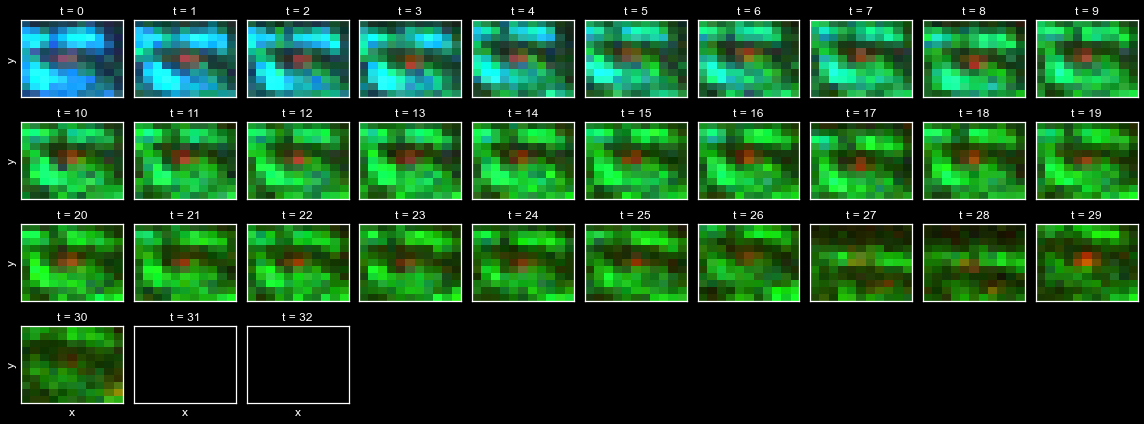

In [8]:
# Plot one of the crops over time to test
best_z = ca.best_z_proj(my_ca, ref_ch=0, disk_r=3, roll_n=3)
best_z.where(my_ca.id==25).mean('n').sel(fov=0).plot.imshow(col='t',rgb='ch',col_wrap=10,robust=True,xticks=[],yticks=[],size=1.5)

# Background subtraction

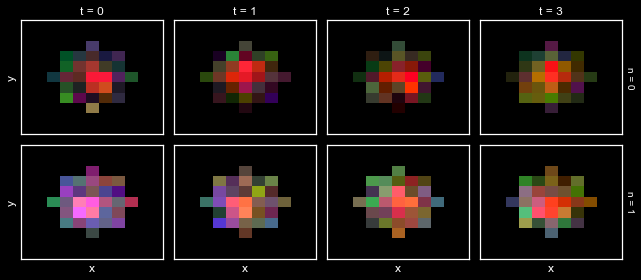

In [10]:
bg = best_z.where(lambda a: (a.x**2 + a.y**2 <= (3*my_ca.dx)**2))
bg.sel(fov=0,t=slice(0,3),n=slice(0,1)).plot.imshow(col='t',row='n',rgb='ch',yticks=[],xticks=[],robust=True,size=2)

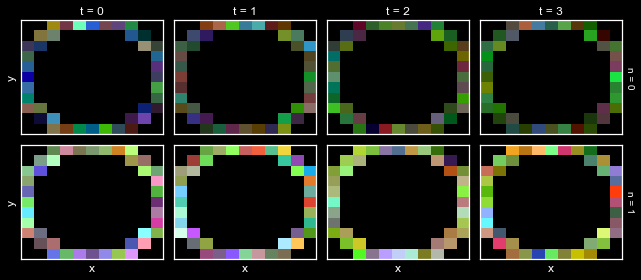

In [12]:
best_z = ca.best_z_proj(my_ca, ref_ch=0, disk_r=3, roll_n=3)
bg = best_z.where(lambda a: (a.x**2 + a.y**2 >= (5*my_ca.dx)**2) & (a.x**2 + a.y**2 < (6*my_ca.dx)**2))
bg.sel(fov=0,t=slice(0,3),n=slice(0,1)).plot.imshow(col='t',row='n',rgb='ch',yticks=[],xticks=[],robust=True,size=2)

In [13]:
donut_sig = bg.mean(dim=['x','y'])
best_z - donut_sig

<xarray.DataArray 'int' (ch: 3, fov: 1, n: 104, t: 33, y: 11, x: 11)>
array([[[[[[-2.7750e+00,  2.2500e-01,  9.2250e+00, ...,  1.2250e+00,
            -2.7750e+00,  2.2250e+00],
           [-1.7750e+00, -7.7750e+00, -7.7500e-01, ..., -7.7500e-01,
             6.2250e+00, -2.7750e+00],
           [ 1.0225e+01,  5.2250e+00,  3.2250e+00, ..., -7.7500e-01,
            -7.7750e+00, -2.7750e+00],
           ...,
           [-7.7500e-01, -5.7750e+00,  2.2500e-01, ..., -7.7750e+00,
             1.2225e+01, -1.7750e+00],
           [ 4.2250e+00,  9.2250e+00,  6.2250e+00, ..., -4.7750e+00,
            -9.7750e+00,  1.6225e+01],
           [ 2.2250e+00, -5.7750e+00,  1.3225e+01, ..., -4.7750e+00,
             7.2250e+00, -5.7750e+00]],

          [[-9.2750e+00, -4.2750e+00, -6.2750e+00, ...,  6.7250e+00,
            -7.2750e+00, -1.0275e+01],
           [ 7.2500e-01, -3.2750e+00, -1.2750e+00, ..., -8.2750e+00,
            -2.2750e+00, -2.2750e+00],
           [ 1.7250e+00, -1.2750e+00, -2.7500e-01, ..., -1.2750e+00,
            -4.2750e+00,  8.7250e+00],
...
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00],
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00],
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00]],

          [[ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00],
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00],
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00],
           ...,
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00],
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00],
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00]]]]]])
Coordinates:
  * fov      (fov) int32 0
  * n        (n) int64 0 1 2 3 4 5 6 7 8 9 ... 94 95 96 97 98 99 100 101 102 103
  * t        (t) int32 0 1 2 3 4 5 6 7 8 9 10 ... 23 24 25 26 27 28 29 30 31 32
    z        (fov, n, t) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
  * y        (y) int32 -650 -520 -390 -260 -130 0 130 260 390 520 650
  * x        (x) int32 -650 -520 -390 -260 -130 0 130 260 390 520 650
  * ch       (ch) int64 0 1 2

# Disk-donut intensity quantification

The following code does disk-donut quantification on the best-z slices to measure signal intensities. Need to implement this i|nto a function.

In [14]:
# Create best-z projection (if not already)
best_z = ca.best_z_proj(my_ca, ref_ch=0, disk_r=3, roll_n=3)

# disk has radius of 3 pixels:
disk_sig = best_z.where(lambda a: a.x**2 + a.y**2 <= (3*my_ca.dx)**2).mean(dim=['x','y'])
# donut has width 1 pixel with inner radius of 5 pixels:
donut_sig = best_z.where(lambda a: (a.x**2 + a.y**2 >= (5*my_ca.dx)**2) & (a.x**2 + a.y**2 < (6*my_ca.dx)**2)).mean(dim=['x','y'])
signal = disk_sig - donut_sig 
best_z_bg = best_z - donut_sig
my_ca['signal'] = signal
my_ca

<xarray.Dataset>
Dimensions:         (fov: 1, n: 104, t: 33, z: 7, y: 11, x: 11, ch: 3)
Coordinates:
  * fov             (fov) int32 0
  * n               (n) int64 0 1 2 3 4 5 6 7 8 ... 96 97 98 99 100 101 102 103
  * t               (t) int32 0 1 2 3 4 5 6 7 8 9 ... 24 25 26 27 28 29 30 31 32
  * z               (z) int32 0 500 1000 1500 2000 2500 3000
  * y               (y) int32 -650 -520 -390 -260 -130 0 130 260 390 520 650
  * x               (x) int32 -650 -520 -390 -260 -130 0 130 260 390 520 650
  * ch              (ch) int64 0 1 2
Data variables:
    int             (fov, n, t, z, y, x, ch) int32 23 17 37 21 37 ... 0 0 0 0 0
    xc              (fov, n, t, ch) int32 75 75 75 75 75 75 75 ... 0 0 0 0 0 0 0
    yc              (fov, n, t, ch) int32 20 20 20 19 19 19 20 ... 0 0 0 0 0 0 0
    dx              int32 130
    dy              int32 130
    dz              int32 500
    dt              int32 1
    id              (fov, n, t) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ID              (fov, n, t) float64 1.078e+04 1.131e+04 ... 0.0 0.0
    MEAN_INTENSITY  (fov, n, t) float64 1.097e+03 1.136e+03 1.13e+03 ... 0.0 0.0
    signal          (ch, fov, n, t) float64 10.78 11.38 13.0 ... 0.0 0.0 0.0
Attributes:
    units:    ['nm', 's']
    name:     ../database/Hela_confocal.tif
    date:     2021-12-25
    notes:    A crop array with ch0 = MYH9 mRNA, ch1 = nascent myo2A peptide ...

Now that we have a signal, we can analyze the mRNA intensity data easily: 

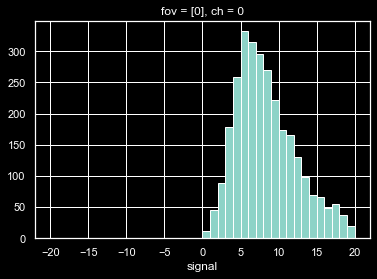

In [15]:
my_ca.signal.where(my_ca.signal>0).sel(ch=0).plot.hist(bins=40, range=(-20,20));

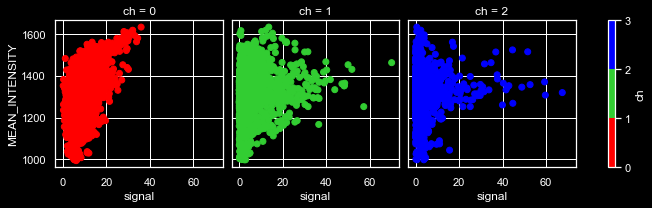

In [16]:
my_ca.where(my_ca.signal>0).plot.scatter(x='signal',y='MEAN_INTENSITY',col='ch',hue='ch',colors=['red','limegreen','blue'],levels=[0,1,2,3])

# Sorting crop ids by average translation signal intensity through time

In [17]:
# Create best-z projection (if not already)
best_z = ca.best_z_proj(my_ca, ref_ch=0, disk_r=2, roll_n=3)

# Make a background subtracted x-array for plotting on same scale
donut_sig = best_z.where(lambda a: (a.x**2 + a.y**2 >= (5*my_ca.dx)**2) & (a.x**2 + a.y**2 < (6*my_ca.dx)**2)).mean(dim=['x','y'])
best_z_bg = best_z -donut_sig

# Now sort based on signal average over time with disk-donut intensity
disk_sig = best_z.where(lambda a: a.x**2 + a.y**2 <= (3*my_ca.dx)**2).mean(dim=['x','y'])
signal = disk_sig - donut_sig
my_ca['signal'] = signal
my_ca['signal'].attrs['notes']='Disk donut on best_z_bg w/ ref_ch=0, disk_r=4, roll_n=3, donut_r = 5-6'

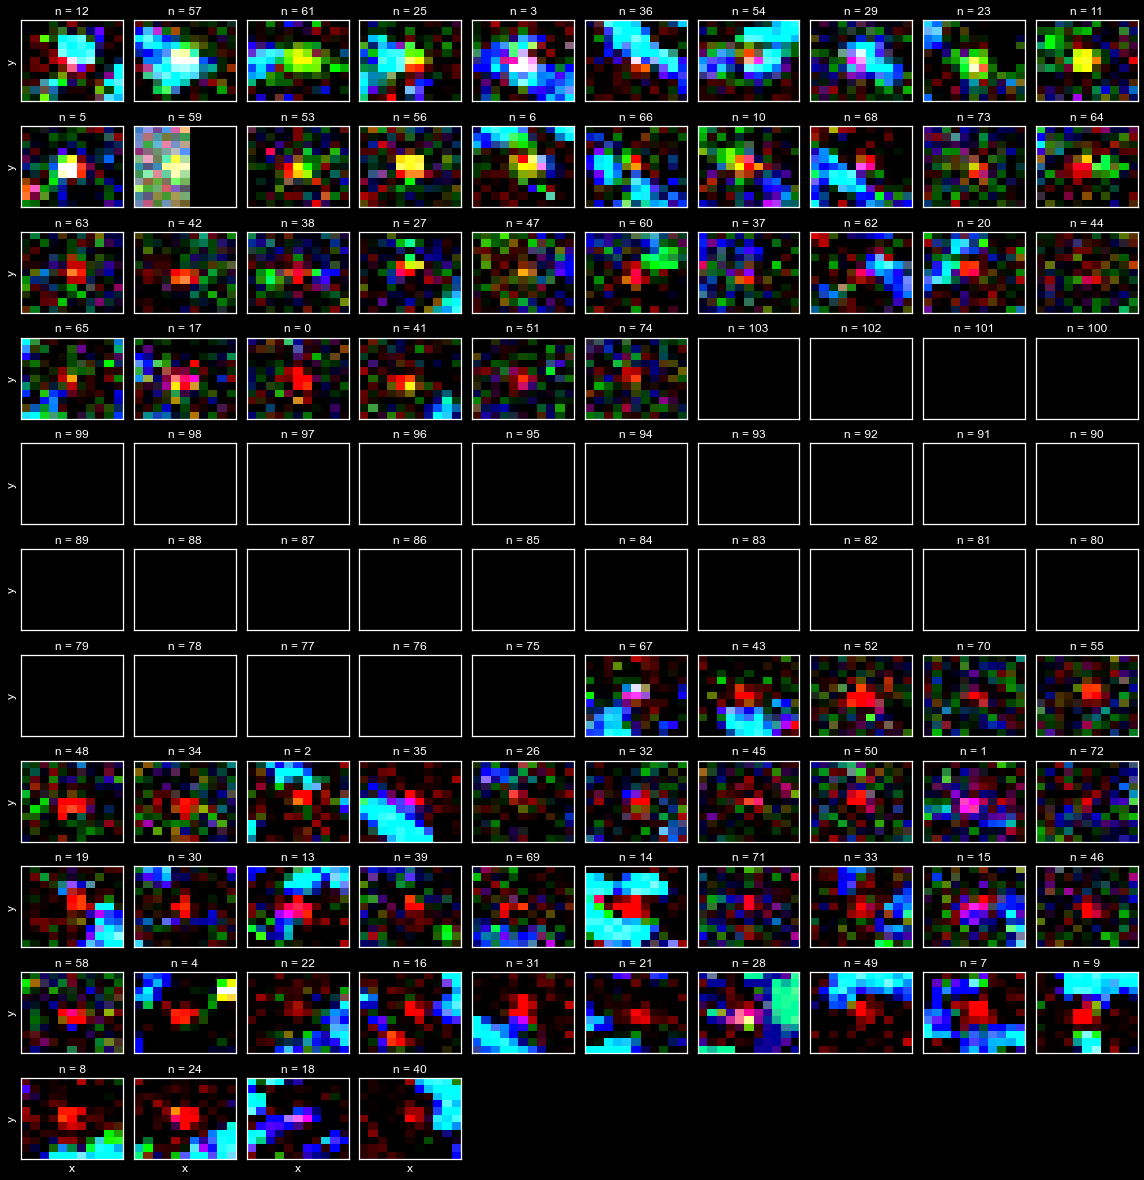

In [18]:
# Visualize the sorted spots t = 0
ca_sort = best_z_bg.sel(t=0).sortby(my_ca.signal.sel(t=0,ch=1,fov=0),ascending=False)
ca_sort.sel(fov=0).plot.imshow(col='n',rgb='ch',col_wrap=10,robust=True,xticks=[],yticks=[],size=1.5,vmin=0,vmax=30)

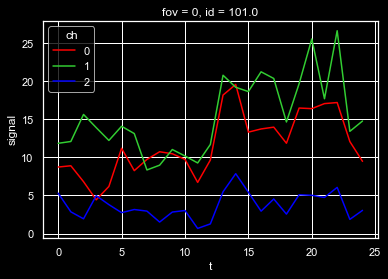

In [19]:
# If ids correspond to tracks, we can also visualize tracks through time  
my_id = np.unique(my_ca.id) # Find all unique ids

# We create a dataset with 'id' as a coordinate in this case
track_sig = xr.concat([my_ca.signal.where(my_ca.id == i).mean(['n']) for i in my_id],dim=pd.Index(my_id, name='id')).to_dataset()

# This allows us to focus on specific tracks in plots:
sns.set_palette(['red','limegreen','blue'])
track_sig.sel(id=101,fov=0).signal.plot.line(x='t',hue='ch')

In [20]:
# Now we sort the trck ids by the mean intensity of each track through time 
# We can look for tracks with bright translation signals, but dim mature protein signals 
# For this, we sort by translation signal - mature protein signal (or could do any variant)
sorted = track_sig.sortby(track_sig.signal.sel(fov=0,ch=1).mean('t'),ascending=False)
sorted_ids = sorted.id.values.astype(int)
sorted_ids

array([104,  19,  69, 101, 223,  92, 263, 255,  91, 231, 113,  94,  70,
       269, 143, 193,  43,  17,  11,   8, 102,  10, 147,  15,  36, 111,
       108, 105,  42, 185, 141,  73,  68, 184,  85,  81, 118,  65, 100,
        22,  47,  67,  52, 189, 166, 129, 219, 300,  16,   9, 278,  71,
        58,  38,  29, 116, 138,  80, 112,  79, 159, 164, 136,   0, 187,
        89, 268,  90,  98, 274,  86,  77, 123,  34,   4, 311,  51, 261,
        39, 124,  54,  84, 256,  61, 248, 122, 115, 106,  62, 194,   6,
       315, 109, 210, 233, 303,  27, 150,  48, 301,  37,  66,  12,  28,
        31,  25,  56,  93,  64,  14])

In [21]:
# To visualize the time-averaged tracks all sorted, we create a crop array and plot it 
sorted_xr = xr.concat([best_z_bg.where(my_ca.id==i, drop=True).mean(dim=['n']) for i in sorted_ids], dim=pd.Index(sorted_ids, name='id'))

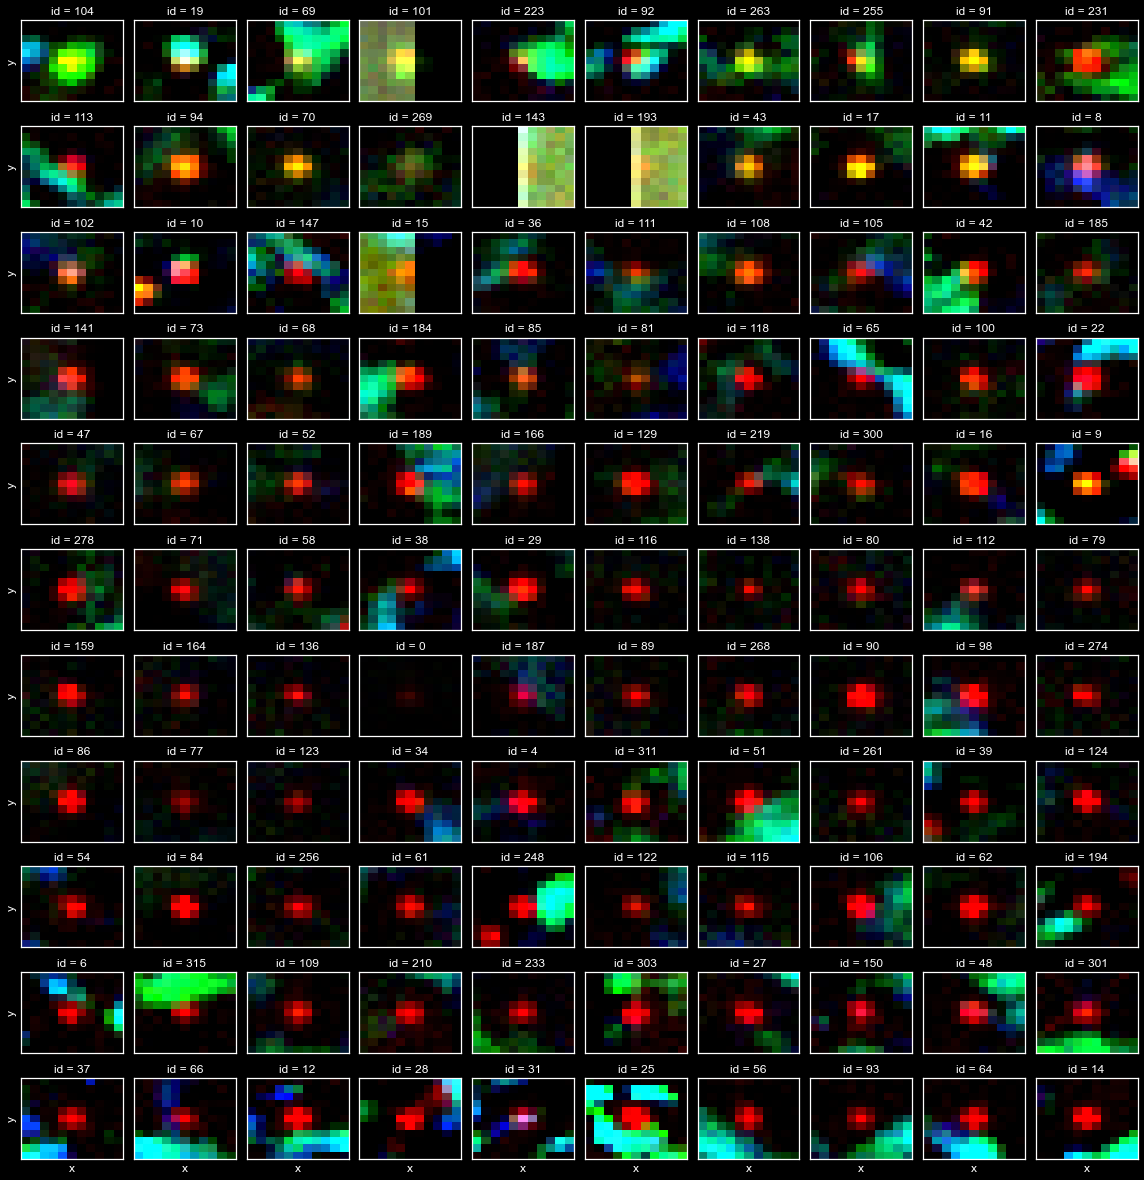

In [22]:
sorted_xr.sel(fov=0).mean('t').plot.imshow(col='id',rgb='ch',col_wrap=10,robust=True,xticks=[],yticks=[],size=1.5, vmin=0, vmax=30)

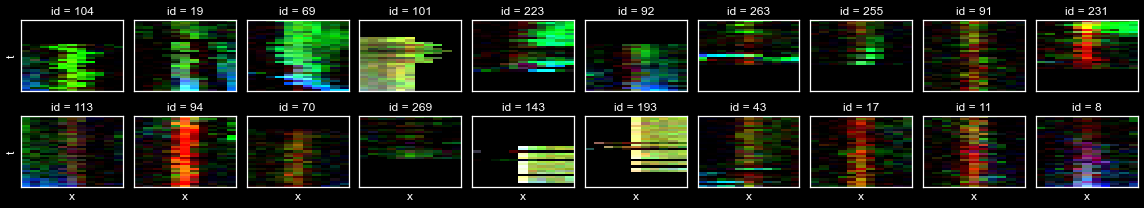

In [23]:
# If you just want to see the first 20:
sorted_xr.isel(fov=0,id=slice(0,20)).mean('y').plot.imshow(col='id',rgb='ch',col_wrap=10,robust=True,xticks=[],yticks=[],size=1.5, vmin=0, vmax=30)

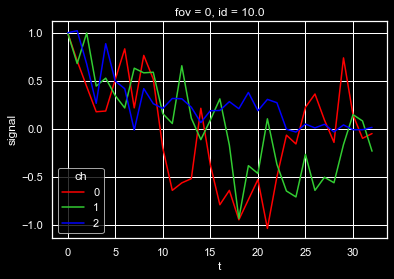

In [24]:
# Now that we've organized things by id (track), we can easily normalize track data
start_sig = track_sig.sel(t=slice(0,0)).mean('t')
end_sig = track_sig.sel(t=slice(30,33)).mean('t')
norm_sig = (track_sig - end_sig)/(start_sig - end_sig)
sns.set_palette(['red','limegreen','blue'])
norm_sig.sel(id=10,fov=0).signal.plot.line(x='t',hue='ch')


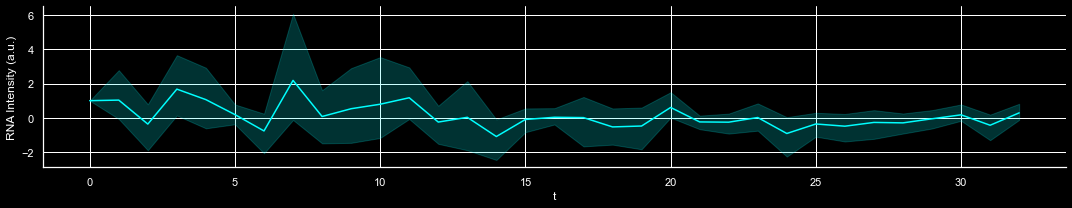

In [25]:
sns.set_palette(['cyan'])
my_data = norm_sig.signal.sel(fov=0,ch=2).to_pandas()
g=sns.relplot(x='t', y='RNA Intensity (a.u.)',data=pd.melt(my_data,value_name="RNA Intensity (a.u.)").dropna(),kind='line',height=3,aspect=5)


In [26]:
donut_sanity_check = best_z_bg.where(lambda x: (x.x**2 + x.y**2 >= (my_ca.dx*5)**2) & (x.x**2 + x.y**2 < (my_ca.dx*6)**2)).mean(dim=['x','y'])

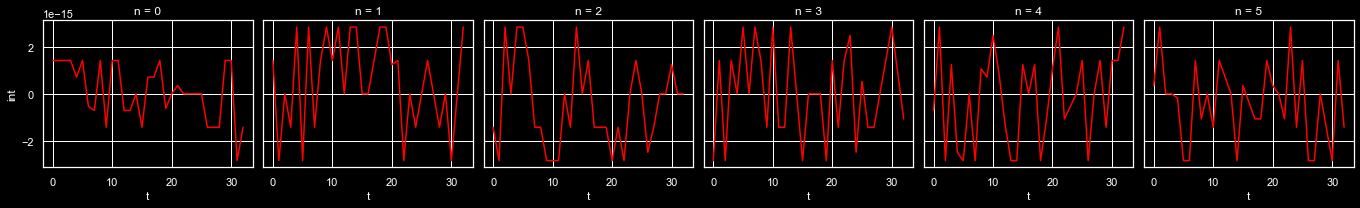

In [27]:
sns.set_palette(['red'])
donut_sanity_check.sel(fov=0,ch=0,n=slice(0,5)).plot(col='n',hue='ch',col_wrap=6)

# Writing and reading crop arrays using netcdf file format

In [28]:
my_ca

<xarray.Dataset>
Dimensions:         (fov: 1, n: 104, t: 33, z: 7, y: 11, x: 11, ch: 3)
Coordinates:
  * fov             (fov) int32 0
  * n               (n) int64 0 1 2 3 4 5 6 7 8 ... 96 97 98 99 100 101 102 103
  * t               (t) int32 0 1 2 3 4 5 6 7 8 9 ... 24 25 26 27 28 29 30 31 32
  * z               (z) int32 0 500 1000 1500 2000 2500 3000
  * y               (y) int32 -650 -520 -390 -260 -130 0 130 260 390 520 650
  * x               (x) int32 -650 -520 -390 -260 -130 0 130 260 390 520 650
  * ch              (ch) int64 0 1 2
Data variables:
    int             (fov, n, t, z, y, x, ch) int32 23 17 37 21 37 ... 0 0 0 0 0
    xc              (fov, n, t, ch) int32 75 75 75 75 75 75 75 ... 0 0 0 0 0 0 0
    yc              (fov, n, t, ch) int32 20 20 20 19 19 19 20 ... 0 0 0 0 0 0 0
    dx              int32 130
    dy              int32 130
    dz              int32 500
    dt              int32 1
    id              (fov, n, t) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ID              (fov, n, t) float64 1.078e+04 1.131e+04 ... 0.0 0.0
    MEAN_INTENSITY  (fov, n, t) float64 1.097e+03 1.136e+03 1.13e+03 ... 0.0 0.0
    signal          (ch, fov, n, t) float64 10.78 11.38 13.0 ... 0.0 0.0 0.0
Attributes:
    units:    ['nm', 's']
    name:     ../database/Hela_confocal.tif
    date:     2021-12-25
    notes:    A crop array with ch0 = MYH9 mRNA, ch1 = nascent myo2A peptide ...

In [29]:
my_ca.attrs['units']='nm and s'

In [30]:
my_ca.to_netcdf('my_crop_array.nc')

In [31]:
test = xr.open_dataset("my_crop_array.nc")
test

<xarray.Dataset>
Dimensions:         (n: 104, t: 33, y: 11, x: 11, z: 7, ch: 3, fov: 1)
Coordinates:
  * n               (n) int32 0 1 2 3 4 5 6 7 8 ... 96 97 98 99 100 101 102 103
  * t               (t) int32 0 1 2 3 4 5 6 7 8 9 ... 24 25 26 27 28 29 30 31 32
  * y               (y) int32 -650 -520 -390 -260 -130 0 130 260 390 520 650
  * x               (x) int32 -650 -520 -390 -260 -130 0 130 260 390 520 650
  * z               (z) int32 0 500 1000 1500 2000 2500 3000
  * ch              (ch) int32 0 1 2
  * fov             (fov) int32 0
Data variables:
    signal          (ch, fov, n, t) float64 ...
    int             (fov, n, t, z, y, x, ch) int32 ...
    xc              (fov, n, t, ch) int32 ...
    yc              (fov, n, t, ch) int32 ...
    id              (fov, n, t) float64 ...
    ID              (fov, n, t) float64 ...
    MEAN_INTENSITY  (fov, n, t) float64 ...
    dx              int32 ...
    dy              int32 ...
    dz              int32 ...
    dt              int32 ...
Attributes:
    units:    nm and s
    name:     ../database/Hela_confocal.tif
    date:     2021-12-25
    notes:    A crop array with ch0 = MYH9 mRNA, ch1 = nascent myo2A peptide ...

# Testing O'Neil's dataset

In [2]:
# Read in csv; note minimal need columns to be used for fov = field of view, f = frame, id = crop/track id #, yc = y-center position of crop, xc - x-center position of crop
spots = pd.read_csv(os.path.join('../database/Data From ONeil', r'cell_nucID_Spot_Intensity_DonutBkg_0_211110233709.csv')) 
# Rename the Trackmate columns to crop array standards of fov, f, id, yc, and xc
spots.rename(columns={'image':'fov', 'Y': 'yc','X': 'xc'}, inplace=True, errors='raise')
spots['f']=0
spots = spots[spots['Ch']==3]  # Has row for every channel
spots['id']=spots.index
# Carry through some of the important columns for the crop array
spots=spots[['fov','id','f','yc','xc','MeanSub','cellid','nucid','cytoid']]
spots.head()

,fov,id,f,yc,xc,MeanSub,cellid,nucid,cytoid
2,052121_Hela_CBS_C+A_48h_Flag TR_MCP JF646_100x...,2,0,15.0,555.0,3935.9,1,1,0
6,052121_Hela_CBS_C+A_48h_Flag TR_MCP JF646_100x...,6,0,18.5,203.0,10358.3,3,0,1
10,052121_Hela_CBS_C+A_48h_Flag TR_MCP JF646_100x...,10,0,18.5,255.5,3648.1,3,0,1
14,052121_Hela_CBS_C+A_48h_Flag TR_MCP JF646_100x...,14,0,25.4,186.4,7992.1,3,0,1
18,052121_Hela_CBS_C+A_48h_Flag TR_MCP JF646_100x...,18,0,26.5,327.5,2730.8,3,0,1


In [3]:
# Read in video; note I added an fov dimension using np.array since this is only 1 fov
video_1 = np.array([imread(os.path.join('../database/Data From ONeil','052121_Hela_CBS_C+A_48h_Flag TR_MCP JF646_100x_ - 1_c405_c488_c561_c640.tiff'))])
video_2 = np.array([imread(os.path.join('../database/Data From ONeil','052121_Hela_CBS_GL2_48h_Flag TR_MCP JF646_100x_ - 1_c405_c488_c561_c640.tiff'))])
video_2.shape # dimensions MUST be (fov, f = frame, z, y, x, ch)
video=np.array([video_1[:,0:18],video_2])
# fov, f, z, y, x, ch  --> fov, f, z, y, x, ch
video.shape

(2, 1, 18, 928, 624, 4)

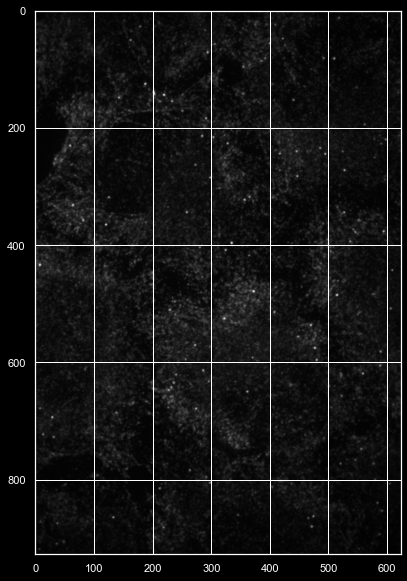

In [4]:
# Just examining one of the images
f = plt.figure(figsize=(10,10))
myimg=np.max(video_2.squeeze(),axis=0)[:,:,2]
plt.imshow(myimg,cmap='gray')

In [5]:
my_ca = ca.create_crop_array(video,spots,xy_pad=5)
my_ca

Original video dimensions:  (2, 1, 18, 928, 624, 4)
Padded video dimensions:  (2, 1, 18, 940, 636, 4)
Max # of spots per frame:  481
Shape of numpy array to hold all crop intensity data:  (2, 481, 1, 18, 11, 11, 4)
Shape of xc and yc numpy arrays:  (2, 481, 1, 4)
Shape of extra my_layers numpy array:  (5, 2, 481, 1)


<xarray.Dataset>
Dimensions:  (fov: 2, n: 481, t: 1, z: 18, y: 11, x: 11, ch: 4)
Coordinates:
  * fov      (fov) int32 0 1
  * n        (n) int64 0 1 2 3 4 5 6 7 8 ... 472 473 474 475 476 477 478 479 480
  * t        (t) int32 0
  * z        (z) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17
  * y        (y) int32 -5 -4 -3 -2 -1 0 1 2 3 4 5
  * x        (x) int32 -5 -4 -3 -2 -1 0 1 2 3 4 5
  * ch       (ch) int32 0 1 2 3
Data variables:
    int      (fov, n, t, z, y, x, ch) int32 787 1594 1184 1171 1912 ... 0 0 0 0
    xc       (fov, n, t, ch) int32 561 561 561 561 209 209 209 ... 0 0 0 0 0 0 0
    yc       (fov, n, t, ch) int32 21 21 21 21 24 24 24 24 ... 0 0 0 0 0 0 0 0
    dx       int32 1
    dy       int32 1
    dz       int32 1
    dt       int32 1
    id       (fov, n, t) float64 2.0 6.0 10.0 14.0 18.0 ... 0.0 0.0 0.0 0.0 0.0
    MeanSub  (fov, n, t) float64 3.936e+03 1.036e+04 3.648e+03 ... 0.0 0.0 0.0
    cellid   (fov, n, t) float64 1.0 3.0 3.0 3.0 3.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
    nucid    (fov, n, t) float64 1.0 0.0 0.0 0.0 0.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
    cytoid   (fov, n, t) float64 0.0 1.0 1.0 1.0 1.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    units:    ['space', 'time']
    name:     video_filename
    date:     video_date

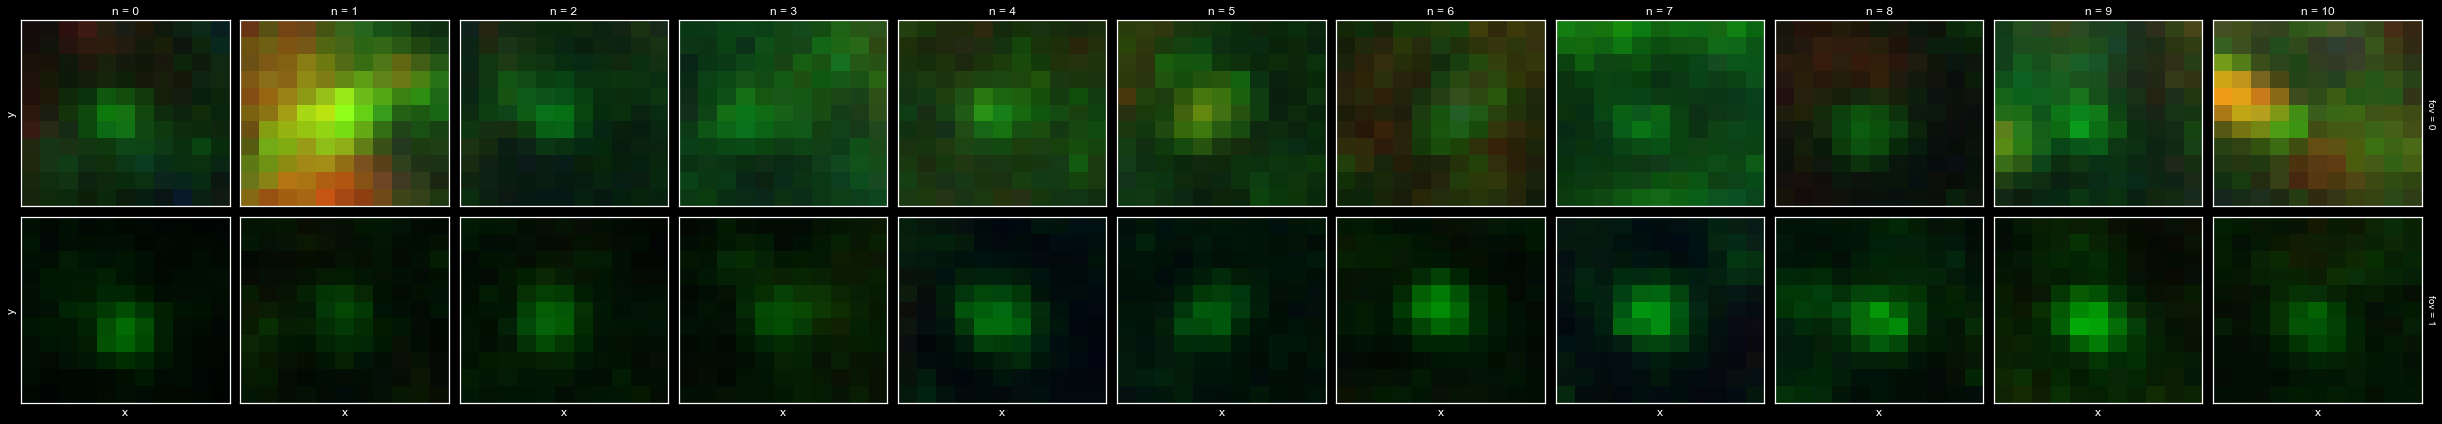

In [62]:
# Check the first 10 spots (max-z projected) of each fov to make sure things are centered. 
# Choosing ch = 1, 2 (translation), and 3 for rgb mapping
my_ca.int.sel(ch=[1,2,3],n=slice(0,10)).mean(dim=['t']).max('z').plot.imshow(col='n',row='fov',rgb='ch',cmap='gray',xticks=[],yticks=[])

In [63]:
# Create best-z projection using channel 2 (translation) as a reference. taking bestz +/- 1 here (roll_n = 3)
best_z = ca.best_z_proj(my_ca, ref_ch=2, disk_r=3, roll_n=3)
best_z = my_ca.int.max('z')

# measure intensity in disk with radius of 3 pixels:
disk_sig = best_z.where(lambda a: a.x**2 + a.y**2 <= (3*my_ca.dx)**2).mean(dim=['x','y'])

# measure intensity in donut with width 1 pixel and inner radius of 5 pixels:
donut_sig = best_z.where(lambda a: (a.x**2 + a.y**2 >= (5*my_ca.dx)**2) & (a.x**2 + a.y**2 < (6*my_ca.dx)**2)).mean(dim=['x','y'])

# disk-donut intensity quantification
signal = disk_sig - donut_sig 

# create a best-z projection that is background subtracted
best_z_bg = best_z -donut_sig

# add signal layer to original crop array for sorting and things
my_ca['signal'] = signal

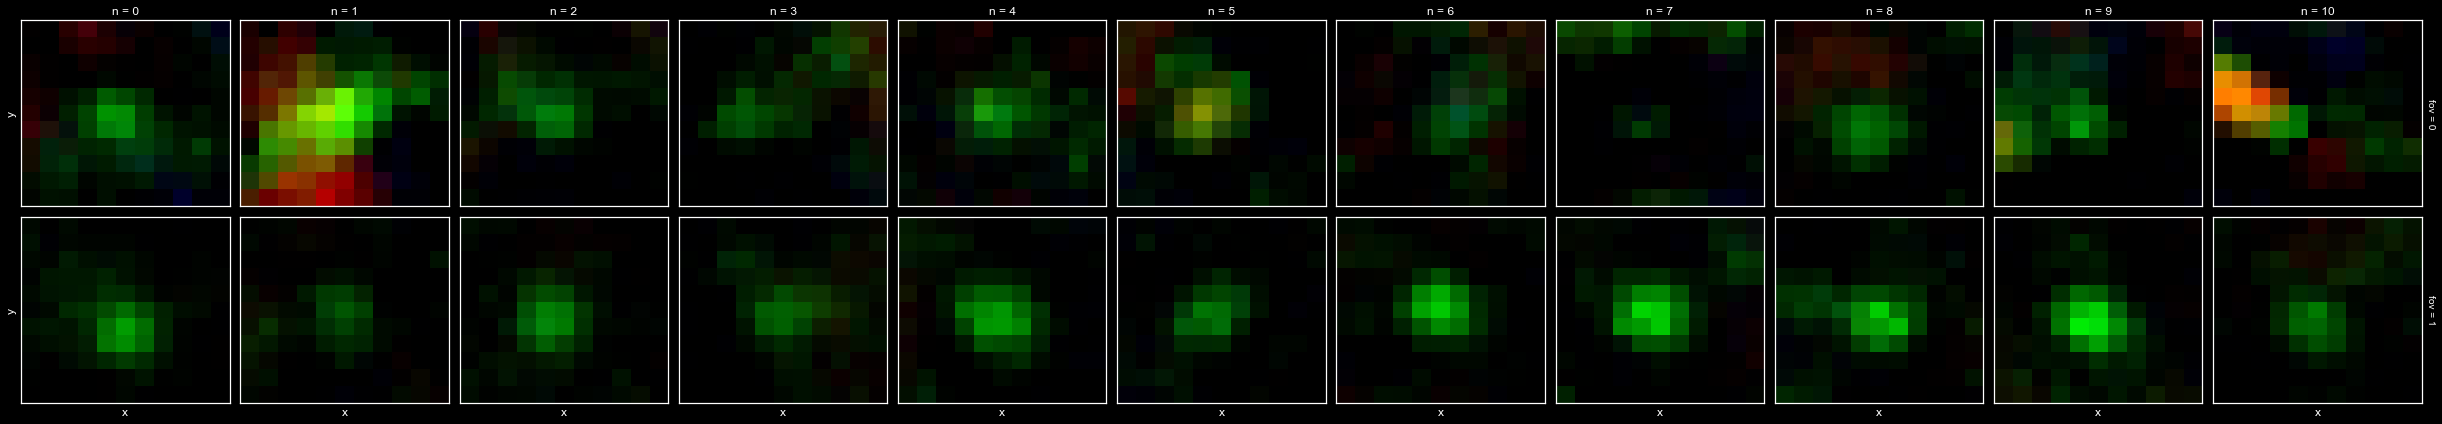

In [64]:
# Repeat measurement above, but looking at background-subtracted image instead of standard max-projection
# You can see a big improvement in signal, by taking the best plane... Can get slighly better with roll_n = 1 above, but more noisy?
best_z_bg.sel(ch=[1,2,3],n=slice(0,10)).mean(dim=['t']).plot.imshow(col='n',row='fov',rgb='ch',cmap='gray',xticks=[],yticks=[],vmin=0, vmax=30000,aspect=1)

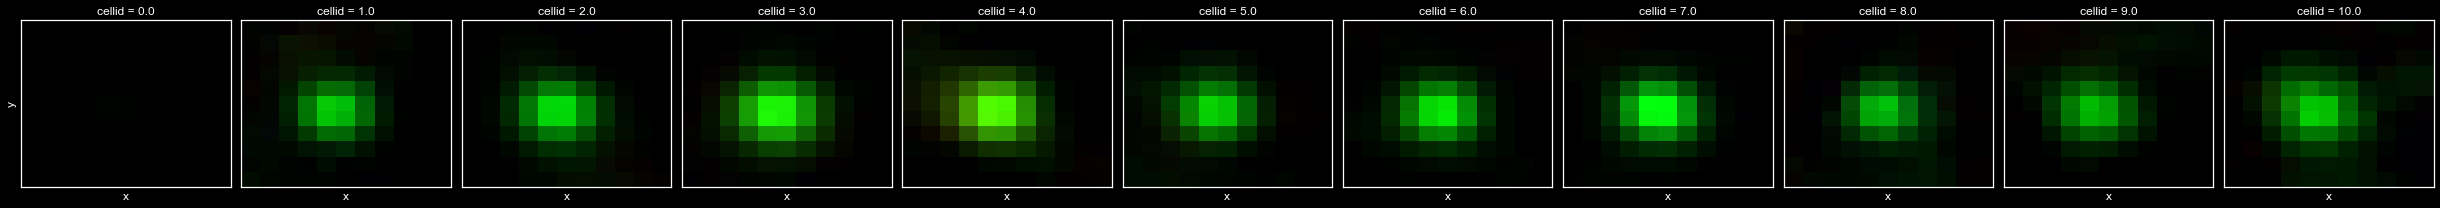

In [65]:
# Let's compare the average spot from different cells 
# Repeat measurement above, but looking at background-subtracted image instead of standard max-projection
# You can see a big improvement in signal, by taking the best plane... Can get slighly better with roll_n = 1 above, but more noisy?
cell_ids= np.unique(my_ca.cellid)
cells = xr.concat([best_z_bg.where(my_ca.cellid==i) for i in cell_ids],dim=pd.Index(cell_ids, name='cellid')).to_dataset()
cells.int.sel(ch=[1,2,3]).mean(dim=['t','n','fov']).plot.imshow(col='cellid', rgb='ch',cmap='gray',xticks=[],yticks=[],vmin=0,vmax=30000)

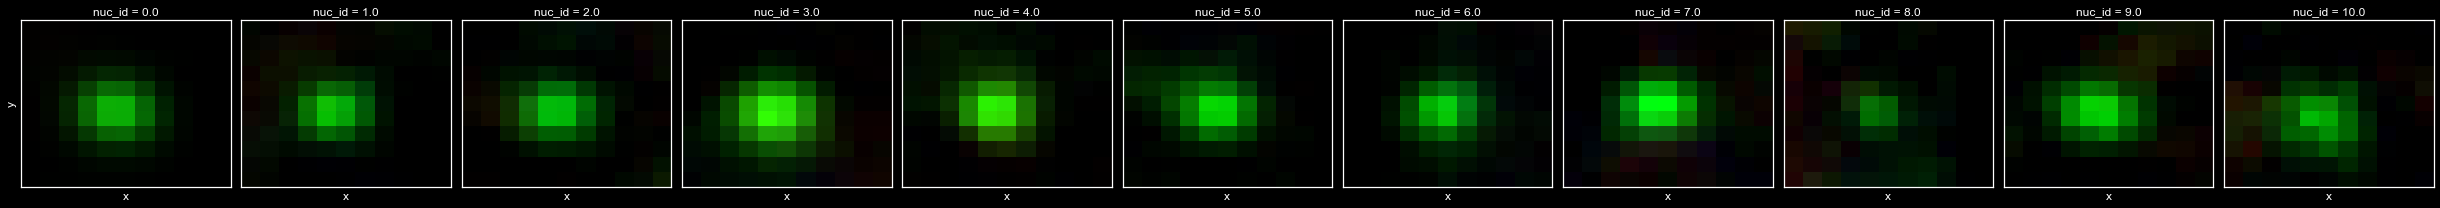

In [66]:
# Now let's look at the spots in/over the nucleus:
my_ids= np.unique(my_ca.nucid)
cells = xr.concat([best_z_bg.where(my_ca.nucid==i) for i in my_ids],dim=pd.Index(my_ids, name='nuc_id')).to_dataset()
cells.int.sel(ch=[1,2,3]).mean(dim=['t','n','fov']).plot.imshow(col='nuc_id', rgb='ch',cmap='gray',xticks=[],yticks=[],vmin=0,vmax=30000)

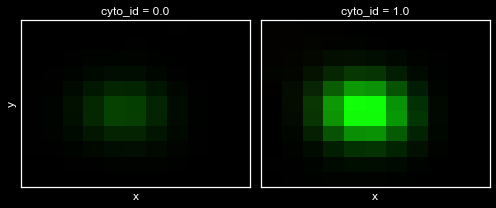

In [67]:
# Now let's look at the spots in/over the cytoplasm: can tell translation signal is way higher:
my_ids= np.unique(my_ca.cytoid)
cells = xr.concat([best_z_bg.where(my_ca.cytoid==i) for i in my_ids],dim=pd.Index(my_ids, name='cyto_id')).to_dataset()
cells.int.sel(ch=[1,2,3]).mean(dim=['t','n','fov']).plot.imshow(col='cyto_id', rgb='ch',cmap='gray',xticks=[],yticks=[],vmin=0,vmax=30000)

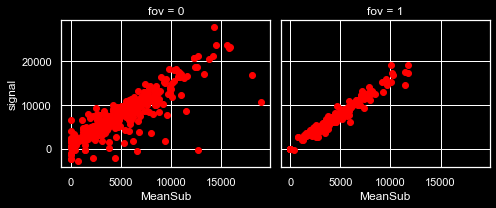

In [68]:
# Let's compare signal measurements;
# Seems to show there are a number of low values in MeanSub that map to high values in signal...hmm
my_ca.sel(ch=2).plot.scatter(x='MeanSub',y='signal',col='fov')

In [70]:
segs = pd.read_pickle(os.path.join('../database/Data From ONeil','trans_mask_coords_pixmap_211110233709.pkl'))

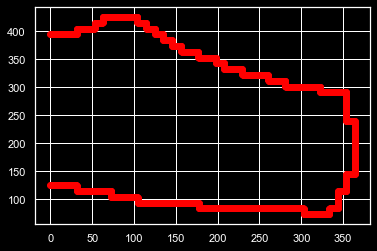

In [71]:
temp = segs[(segs['image']=='052121_Hela_CBS_C+A_48h_Flag TR_MCP JF646_100x_ - 1_c405_c488_c561_c640') & (segs['labelid']==3) & (segs['struct']=='cell')]
(x,y)=(temp['coords'].values)[0].T
plt.scatter(x,y)

In [72]:
#!pip install alphashape
import alphashape

[0.193859649122807, 221, 1140]

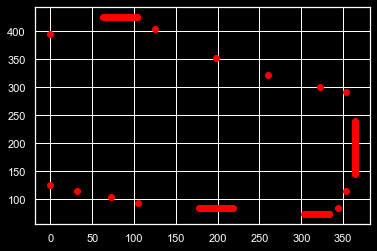

In [73]:
points = (temp['coords'].values)[0]
#alpha = 0.95 * alphashape.optimizealpha(points)
alpha=.003
hull = alphashape.alphashape(points, alpha)
hull_pts = hull.exterior.coords.xy
fig, ax = plt.subplots()
ax.scatter(hull_pts[0], hull_pts[1], color='red')  
[len(hull_pts[0])/len(points), len(hull_pts[0]), len(points)]

In [74]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d

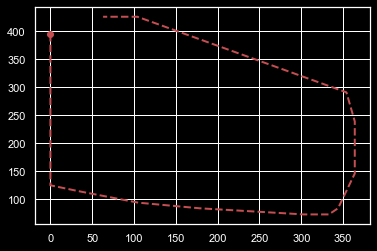

[0.011403508771929825, 13, 1140]

In [75]:
hull = ConvexHull(points)
plt.plot(points[hull.vertices,0], points[hull.vertices,1], 'r--', lw=2)
plt.plot(points[hull.vertices[0],0], points[hull.vertices[0],1], 'ro')
plt.show()
[len(hull.vertices)/len(points), len(hull.vertices), len(points)]

# Visualization and Napari testing

In [17]:
# Enter in the following:
video_3D_directory = r'../database'
video_3D_filename = r'Hela_confocal.tif'        
csv_filename = r'Crops_Hela_confocal.csv'

In [18]:
# Read in video; note I added an fov dimension using np.array since this is only 1 fov
video_3D = np.array([imread(os.path.join(video_3D_directory,video_3D_filename))])
video_3D.shape # dimensions MUST be (fov, f = frame, z, y, x, ch)
# Read in csv; note minimal need columns to be used for fov = field of view, f = frame, id = crop/track id #, yc = y-center position of crop, xc - x-center position of crop
spots = pd.read_csv(os.path.join(video_3D_directory, csv_filename)) 
# Rename the Trackmate columns to crop array standards of fov, f, id, yc, and xc
spots.rename(columns={'POSITION_X': 'xc','POSITION_Y': 'yc', 'FRAME': 'f','TRACK_ID':'id'}, inplace=True, errors='raise')
 # Here we need to create an fov column since there was only 1 fov with the sample dataset. Can give it a name, but note that in the crop array it will be assigned a unique fov integer number starting from 0
spots['fov']=video_3D_filename  
# can include other optional columns for making layers, like 'ID', and 'MEAN_INTENSITY'
spots = spots[['fov','id','f','yc','xc','ID','MEAN_INTENSITY']]  
spots.head()
# create crop array using minimal arguments
my_ca = ca.create_crop_array(video_3D, spots)
my_ca

Original video dimensions:  (1, 33, 7, 472, 312, 3)
Padded video dimensions:  (1, 33, 7, 484, 324, 3)
Max # of spots per frame:  104
Shape of numpy array to hold all crop intensity data:  (1, 104, 33, 7, 11, 11, 3)
Shape of xc and yc numpy arrays:  (1, 104, 33, 3)
Shape of extra my_layers numpy array:  (3, 1, 104, 33)


<xarray.Dataset>
Dimensions:         (fov: 1, n: 104, t: 33, z: 7, y: 11, x: 11, ch: 3)
Coordinates:
  * fov             (fov) int32 0
  * n               (n) int64 0 1 2 3 4 5 6 7 8 ... 96 97 98 99 100 101 102 103
  * t               (t) int32 0 1 2 3 4 5 6 7 8 9 ... 24 25 26 27 28 29 30 31 32
  * z               (z) int32 0 1 2 3 4 5 6
  * y               (y) int32 -5 -4 -3 -2 -1 0 1 2 3 4 5
  * x               (x) int32 -5 -4 -3 -2 -1 0 1 2 3 4 5
  * ch              (ch) int32 0 1 2
Data variables:
    int             (fov, n, t, z, y, x, ch) int32 23 17 37 21 37 ... 0 0 0 0 0
    xc              (fov, n, t, ch) int32 75 75 75 75 75 75 75 ... 0 0 0 0 0 0 0
    yc              (fov, n, t, ch) int32 20 20 20 19 19 19 20 ... 0 0 0 0 0 0 0
    dx              int32 1
    dy              int32 1
    dz              int32 1
    dt              int32 1
    id              (fov, n, t) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ID              (fov, n, t) float64 1.078e+04 1.131e+04 ... 0.0 0.0
    MEAN_INTENSITY  (fov, n, t) float64 1.097e+03 1.136e+03 1.13e+03 ... 0.0 0.0
Attributes:
    units:    ['space', 'time']
    name:     video_filename
    date:     video_date

In [19]:
napari.view_image(ca.montage(my_ca, row = 'n', col = 'n').int.sel(ch=0));

In [20]:
best_z = ca.best_z_proj(my_ca, ref_ch=0, disk_r=3, roll_n=3)
my_ca['best_z'] = best_z

In [21]:
napari.view_image(ca.montage(my_ca, row = 'n', col = 'n').best_z.sel(ch=0));

In [22]:
# Create best-z projection (if not already)
best_z = ca.best_z_proj(my_ca, ref_ch=0, disk_r=2, roll_n=3)

# Make a background subtracted x-array for plotting on same scale
donut_sig = best_z.where(lambda a: (a.x**2 + a.y**2 >= (5*my_ca.dx)**2) & (a.x**2 + a.y**2 < (6*my_ca.dx)**2)).mean(dim=['x','y'])
best_z_bg = best_z -donut_sig
my_ca['best_z'] = best_z_bg

# Now sort based on signal average over time with disk-donut intensity
disk_sig = best_z.where(lambda a: a.x**2 + a.y**2 <= (3*my_ca.dx)**2).mean(dim=['x','y'])
signal = disk_sig - donut_sig
my_ca['signal'] = signal
my_ca['signal'].attrs['notes']='Disk donut on best_z_bg w/ ref_ch=0, disk_r=4, roll_n=3, donut_r = 5-6'

# If ids correspond to tracks, we can also visualize tracks through time  
my_id = np.unique(my_ca.id) # Find all unique ids

# We create a dataset with 'id' as a coordinate in this case
track_sig = xr.concat([my_ca.signal.where(my_ca.id == i).mean(['n']) for i in my_id],dim=pd.Index(my_id, name='id')).to_dataset()

# Now we sort the trck ids by the mean intensity of each track through time 
# We can look for tracks with bright translation signals, but dim mature protein signals 
# For this, we sort by translation signal - mature protein signal (or could do any variant)
sorted = track_sig.sortby(track_sig.signal.sel(fov=0,ch=1).mean('t'),ascending=False)
sorted_ids = sorted.id.values.astype(int)

pad_amount = int((len(my_ca.x)-1)/2)
temp = my_ca.signal.expand_dims('x').pad(pad_width={'x':pad_amount}, mode='edge')
temp = temp.expand_dims('y').pad(pad_width={'y':pad_amount}, mode='edge').assign_coords({'x': my_ca.x,'y':my_ca.y})
my_ca['id_layer'] = temp

# To visualize the time-averaged tracks all sorted, we create a crop array and plot it 
sorted_xr = xr.concat([my_ca.where(my_ca.id==i, drop=True).mean(dim=['n']) for i in sorted_ids], dim=pd.Index(sorted_ids, name='ids'))

In [23]:
sorted_xr

<xarray.Dataset>
Dimensions:         (t: 33, ids: 110, fov: 1, z: 7, y: 11, x: 11, ch: 3)
Coordinates:
  * t               (t) int64 0 1 2 3 4 5 6 7 8 9 ... 24 25 26 27 28 29 30 31 32
  * fov             (fov) int32 0
  * z               (z) int32 0 1 2 3 4 5 6
  * y               (y) int32 -5 -4 -3 -2 -1 0 1 2 3 4 5
  * x               (x) int32 -5 -4 -3 -2 -1 0 1 2 3 4 5
  * ch              (ch) int64 0 1 2
  * ids             (ids) int64 104 19 69 101 223 92 263 ... 31 25 56 93 64 14
Data variables: (12/13)
    int             (ids, fov, t, z, y, x, ch) float64 41.0 86.0 ... nan nan
    xc              (ids, fov, t, ch) float64 125.0 125.0 125.0 ... nan nan nan
    yc              (ids, fov, t, ch) float64 282.0 282.0 282.0 ... nan nan nan
    dx              (ids, fov, t) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 nan nan
    dy              (ids, fov, t) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 nan nan
    dz              (ids, fov, t) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 nan nan
    ...              ...
    id              (ids, fov, t) float64 104.0 104.0 104.0 ... 14.0 nan nan
    ID              (ids, fov, t) float64 1.092e+04 1.144e+04 ... nan nan
    MEAN_INTENSITY  (ids, fov, t) float64 1.407e+03 1.414e+03 ... nan nan
    best_z          (ids, ch, fov, t, y, x) float64 -0.05 2.95 -0.05 ... nan nan
    signal          (ids, ch, fov, t) float64 8.812 11.11 9.452 ... nan nan
    id_layer        (ids, y, x, ch, fov, t) float64 8.812 11.11 ... nan nan

In [24]:
viewer = napari.Viewer()

In [26]:
my_image = ca.montage(sorted_xr.fillna(0), row = 'ids', col = 't')
viewer.add_image(my_image.best_z.sel(ch=1), colormap = 'green', name = 'green', blending = 'additive');

In [27]:
viewer.add_image(my_image.best_z.sel(ch=0), colormap = 'red', name = 'red', blending='additive');

In [28]:
viewer.add_image(my_image.best_z.sel(ch=2), colormap = 'blue', name = 'blue', blending='additive');

In [29]:
viewer.add_image(my_image.id_layer.sel(ch=1), colormap = 'gray', name = 'ids', blending='additive');